In [32]:
import os
from glob import glob
from collections import namedtuple
import xarray as xr
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import cmocean.cm as cmo

In [37]:
CASE = "coupPPE.002"

---

In [ ]:
def get_ClusterClient(
        ncores=1,
        nmem='25GB',
        walltime='01:00:00',
        account='UWAS0155'):
    """
    Code from Daniel Kennedy
    More info about Dask on HPC - https://ncar.github.io/dask-tutorial/notebooks/05-dask-hpc.html
    """
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client

    cluster = PBSCluster(
        cores=ncores,              # The number of cores you want
        memory=nmem,               # Amount of memory
        processes=ncores,          # How many processes
        queue='casper',            # Queue name
        resource_spec='select=1:ncpus=' +\
        str(ncores)+':mem='+nmem,  # Specify resources
        account=account,           # Input your project ID here
        walltime=walltime,         # Amount of wall time
        interface='ext',           # Interface to use
    )

    client = Client(cluster)
    return cluster, client


## Create Dask cluster and client, scale up to 20 workers
if "cluster" not in globals():
    cluster, client = get_ClusterClient(nmem="10GB")
    cluster.scale(5)

    ## Wait for cluster to be set up
    import time
    time.sleep(5)

## Check the status of the cluster
print(client)

## Prints the PBS job script that is used to submit the Dask workers
# print(cluster.job_script())

## Lists active workers and their status
print(cluster.workers)

## Lists current jobs in Casper queue
# !qstat -x -u $USER

## Create the SSH tunnel to access the Dask dashboard locally
port = cluster.dashboard_link.split(":")[2].split("/")[0]
address = cluster.dashboard_link.split(":")[1][2:]
print(f"ssh -N -L {port}:{address}:{port} bbuchovecky@casper.hpc.ucar.edu")  # local command line argument
print(f"http://localhost:{port}/status")  # link to local dask dashboard

<Client: 'tcp://128.117.211.221:46451' processes=0 threads=0, memory=0 B>
{'PBSCluster-3': <dask_jobqueue.pbs.PBSJob: status=running>, 'PBSCluster-0': <dask_jobqueue.pbs.PBSJob: status=running>, 'PBSCluster-4': <dask_jobqueue.pbs.PBSJob: status=running>, 'PBSCluster-2': <dask_jobqueue.pbs.PBSJob: status=running>, 'PBSCluster-1': <dask_jobqueue.pbs.PBSJob: status=running>}
ssh -N -L 8787:128.117.211.221:8787 bbuchovecky@casper.hpc.ucar.edu
http://localhost:8787/status


Task exception was never retrieved
future: <Task finished name='Task-1015555' coro=<Client._gather.<locals>.wait() done, defined at /glade/u/home/bbuchovecky/miniforge3/envs/cpl_ppe_co2/lib/python3.12/site-packages/distributed/client.py:2391> exception=AllExit()>
Traceback (most recent call last):
  File "/glade/u/home/bbuchovecky/miniforge3/envs/cpl_ppe_co2/lib/python3.12/site-packages/distributed/client.py", line 2400, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-1013783' coro=<Client._gather.<locals>.wait() done, defined at /glade/u/home/bbuchovecky/miniforge3/envs/cpl_ppe_co2/lib/python3.12/site-packages/distributed/client.py:2391> exception=AllExit()>
Traceback (most recent call last):
  File "/glade/u/home/bbuchovecky/miniforge3/envs/cpl_ppe_co2/lib/python3.12/site-packages/distributed/client.py", line 2400, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
futur

In [38]:
def _shift_time(da):
    if (da.time[0].dt.month.item() == 2) and (da.time[-1].dt.month.item() == 1):
        new_time = xr.date_range(
            start=str(da.time[0].dt.year.item()) + "-01",
            end=str(da.time[-1].dt.year.item() - 1) + "-12",
            freq="MS",
            calendar="noleap",
            use_cftime=True,
        )
        return da.assign_coords(time=new_time)
    return da


def _get_chunk_size_from_res(case):
    if "f09_f09" in case:
        chunk_size = {"time": 1024}
    else:
        chunk_size = {"time": 2048}
    return chunk_size


def check_frequency(ds):
    time_steps_per_year = len(ds.time) / (ds.time[-1].dt.year - ds.time[0].dt.year + 1)
    if time_steps_per_year == 12:
        freq = "monthly"
    elif time_steps_per_year == 1:
        freq = "yearly"
    else:
        freq = "unknown"
    return freq


def load_variables(varnames, case, basedir, domain="lnd", htape="h0", suffix=""):
    def _keep_var(ds):
        return ds[varnames]

    component = {
        "lnd": "clm2",
        "atm": "cam",
    }

    if len(suffix):
        suffix = "."+suffix

    if varnames:
        data = xr.open_mfdataset(
            f"{basedir}/{case}{suffix}/{domain}/hist/{case}.{component[domain]}.{htape}.*.nc",
            combine="by_coords",
            decode_timedelta=False,
            parallel=True,
            preprocess=_keep_var,
            chunks=_get_chunk_size_from_res(case),
            engine="netcdf4",
        )
    else:
        data = xr.open_mfdataset(
            f"{basedir}/{case}{suffix}/{domain}/hist/{case}.{component[domain]}.{htape}.*.nc",
            combine="by_coords",
            decode_timedelta=False,
            parallel=True,
            chunks=_get_chunk_size_from_res(case),
            engine="netcdf4",
        )

    return _shift_time(data)


SIM_DIR = "/glade/u/home/bbuchovecky/projects/cpl_ppe_co2/sims"
ARCH_DIR = "/glade/derecho/scratch/bbuchovecky/archive"
VARIABLES = ["TLAI", "TOTVEGC", "EFLX_LH_TOT", "FCTR", "FCEV", "FGEV", "TSA"]

cplhist = load_variables(VARIABLES, "f.e21.FHIST_BGC.f19_f19_mg17.historical.coupPPE.cplhist", ARCH_DIR).sel(time=slice("1850-01", "1949-12"))
ihist = load_variables(VARIABLES, f"IHistClm50Bgc.CPLHIST.historical.{CASE}.IHIST", ARCH_DIR)
if glob(f"{ARCH_DIR}/f.e21.FHIST_BGC.f19_f19_mg17.historical.{CASE}"):
    fhist = load_variables(VARIABLES, f"f.e21.FHIST_BGC.f19_f19_mg17.historical.{CASE}", ARCH_DIR)

fh0 = glob(f"{ARCH_DIR}/IHistClm50Bgc.CPLHIST.historical.{CASE}.IHIST/lnd/hist/*.h0.*")
grid = xr.open_dataset(fh0[0], decode_timedelta=True, engine="netcdf4")[["area", "landfrac"]]
la = (grid.area * 1e6 * grid.landfrac).fillna(0).compute()  #m2
lw = (la / la.sum()).compute()

ConversionFactor = namedtuple("ConversionFactor", ["cf", "cs", "unit", "kind"])
cfs = {
    "TLAI": ConversionFactor(lw, 0, "m2/m2", "intensive"),
    "TOTECOSYSC": ConversionFactor(la/ 0,1e15, "PgC", "extensive"),
    "TOTVEGC": ConversionFactor(la/1e15, 0, "PgC", "extensive"),
    "TOTSOMC": ConversionFactor(la/1e15, 0, "PgC", "extensive"),
    "RAIN": ConversionFactor(lw, 0, "mm/s", "intensive"),
    "QRUNOFF": ConversionFactor(lw, 0, "mm/s", "intensive"),
    "QSOIL": ConversionFactor(lw, 0, "mm/s", "intensive"),
    "QVEGE": ConversionFactor(lw, 0, "mm/s", "intensive"),
    "QVEGT": ConversionFactor(lw, 0, "mm/s", "intensive"),
    "TWS": ConversionFactor(lw, 0, "mm", "intensive"),
    "EFLX_LH_TOT": ConversionFactor(lw, 0, "W/m2", "intensive"),
    "FCTR": ConversionFactor(lw, 0, "W/m2", "intensive"),
    "FCEV": ConversionFactor(lw, 0, "W/m2", "intensive"),
    "FGEV": ConversionFactor(lw, 0, "W/m2", "intensive"),
    "FSH": ConversionFactor(lw, 0, "W/m2", "intensive"),
    "FIRE": ConversionFactor(lw, 0, "W/m2", "intensive"),
    "FLDS": ConversionFactor(lw, 0, "W/m2", "intensive"),
    "FSR": ConversionFactor(lw, 0, "W/m2", "intensive"),
    "FSDS": ConversionFactor(lw, 0, "W/m2", "intensive"),
    "FGR": ConversionFactor(lw, 0, "W/m2", "intensive"),
    "TSA": ConversionFactor(lw, -273.15, "degreeC", "intensive"),
}
labels = {
    "intensive": "mean",
    "extensive": "total"
}
cmaps = {
    "veg": {
        "diff": "PRGn",
        "cont": "viridis",
        "vars": ["TLAI", "TOTVEGC"]},
    "water": {
        "diff": cmo.curl_r,
        "cont": cmo.rain,
        "vars": ["EFLX_LH_TOT", "FCTR", "FCEV", "FGEV"]},
    "temp": {
        "diff": "RdBu_r",
        "cont": "inferno",
        "vars": ["TSA"]},
}

KeyboardInterrupt: 

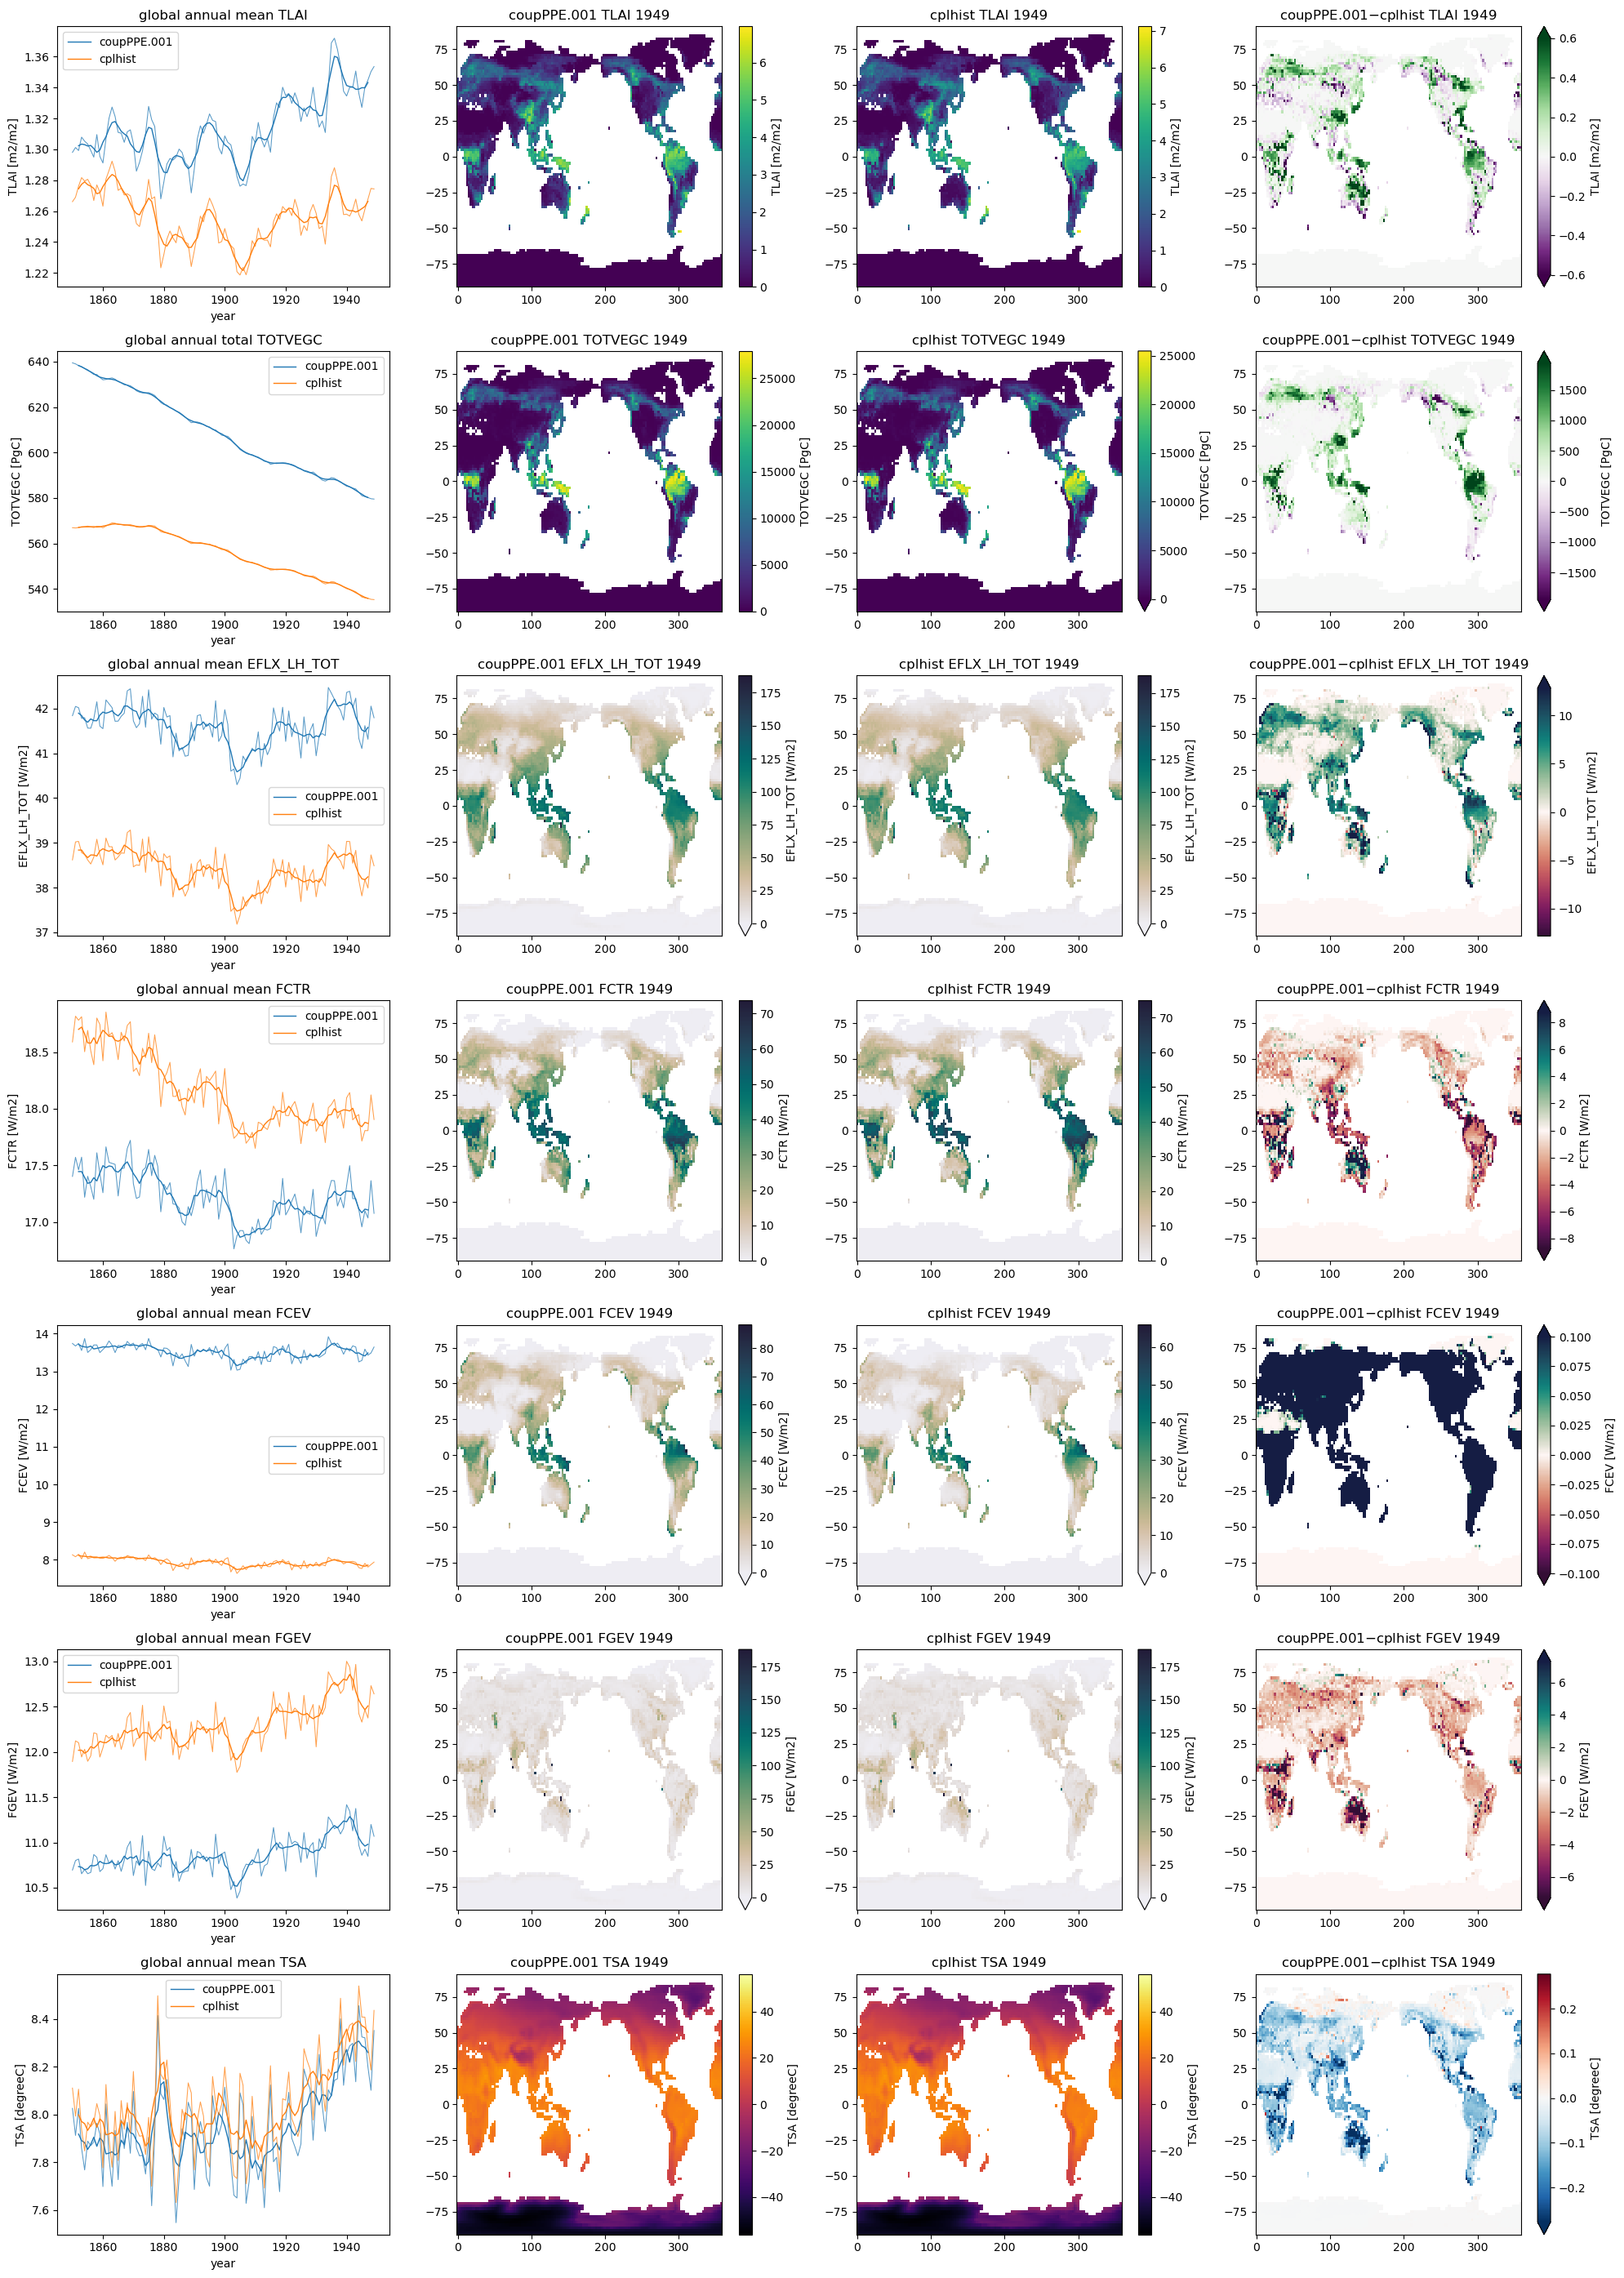

In [ ]:
fig, axes = plt.subplots(nrows=len(VARIABLES), ncols=4, figsize=(20, 4*len(VARIABLES)), layout="tight")
ax = axes.flatten()
for i,v in enumerate(VARIABLES):

    if v in cmaps["veg"]["vars"]: cm = cmaps["veg"]
    elif v in cmaps["water"]["vars"]: cm = cmaps["water"]
    elif v in cmaps["temp"]["vars"]: cm = cmaps["temp"]

    vmin = 0
    if v == "TSA":
        vmin = None

    ihist_ann = ((ihist[v]+cfs[v].cs)*cfs[v].cf).sum(dim=["lat","lon"]).groupby("time.year").mean().compute()
    cplhist_ann = ((cplhist[v]+cfs[v].cs)*cfs[v].cf).sum(dim=["lat","lon"]).groupby("time.year").mean().compute()

    ihist_ann.plot(ax=ax[4*i], color="tab:blue", alpha=0.75, lw=0.75)
    ihist_ann.rolling(year=5, center=True).mean().plot(ax=ax[4*i], color="tab:blue", alpha=1, lw=1, label=CASE)
    cplhist_ann.plot(ax=ax[4*i], color="tab:orange", alpha=0.75, lw=0.75)
    cplhist_ann.rolling(year=5, center=True).mean().plot(ax=ax[4*i], color="tab:orange", alpha=1, lw=1, label="cplhist")

    ax[4*i].set_ylabel(f"{v} [{cfs[v].unit}]")
    ax[4*i].set_title(f"global annual {labels[cfs[v].kind]} {v}")
    ax[4*i].legend()

    (ihist[v]+cfs[v].cs).sel(time=slice("1949-01", "1949-12")).mean(dim="time").plot(ax=ax[4*i+1], vmin=vmin, cmap=cm["cont"], cbar_kwargs={"label": f"{v} [{cfs[v].unit}]"})
    ax[4*i+1].set_title(f"{CASE} {v} 1949")

    (cplhist[v]+cfs[v].cs).sel(time=slice("1949-01", "1949-12")).mean(dim="time").plot(ax=ax[4*i+2], vmin=vmin, cmap=cm["cont"], cbar_kwargs={"label": f"{v} [{cfs[v].unit}]"})
    ax[4*i+2].set_title(f"cplhist {v} 1949")

    ((ihist[v]+cfs[v].cs).sel(time=slice("1949-01", "1949-12")) - (cplhist[v]+cfs[v].cs).sel(time=slice("1949-01", "1949-12"))).mean(dim="time").plot(ax=ax[4*i+3], cmap=cm["diff"], norm=clr.CenteredNorm(), robust=True, cbar_kwargs={"label": f"{v} [{cfs[v].unit}]"})
    ax[4*i+3].set_title(f"{CASE}$-$cplhist {v} 1949")

    for j in range(1,4):
        ax[4*i+j].set_ylabel("")
        ax[4*i+j].set_xlabel("")

fig.savefig(f"{SIM_DIR}/{CASE}/IHistClm50Bgc.CPLHIST.historical.{CASE}.IHIST.png", dpi=300, bbox_inches="tight")

In [27]:
client.shutdown()
del cluster
del client
!rm ./dask-worker.e*
!rm ./dask-worker.o*